# House Prices - Advanced Regressions Techniques

## Description: 

Using 79 explanatory variables that describes aspects of residential homes, the goal is to predict the final price of each home.

### 1) Setup and libraries

In [1]:
# !pip install feature-engine catboost lightgbm
# !pip install os
# !pip install pandas 
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn

In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


### 2) Data preparation

#### 2.1) Loading data

The dataset is also available in:
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [3]:
folder = os.path.join('D:\diego\OneDrive\Documentos\Data Science\datasets\house-prices')

Loading the inicial database (raw), checking shape and visualizing the first rows

In [4]:
df_raw = pd.read_csv(os.path.join(folder, 'train.csv'))
df_raw.shape

(1460, 81)

In [5]:
df_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Loading the test data (used to submit in Kaggle)

In [6]:
df_test = pd.read_csv(os.path.join(folder, 'test.csv'))
df_test.shape

(1459, 80)

In [7]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#### 2.2) Data Exploration and splitting data

Identifying the columns with more missing values

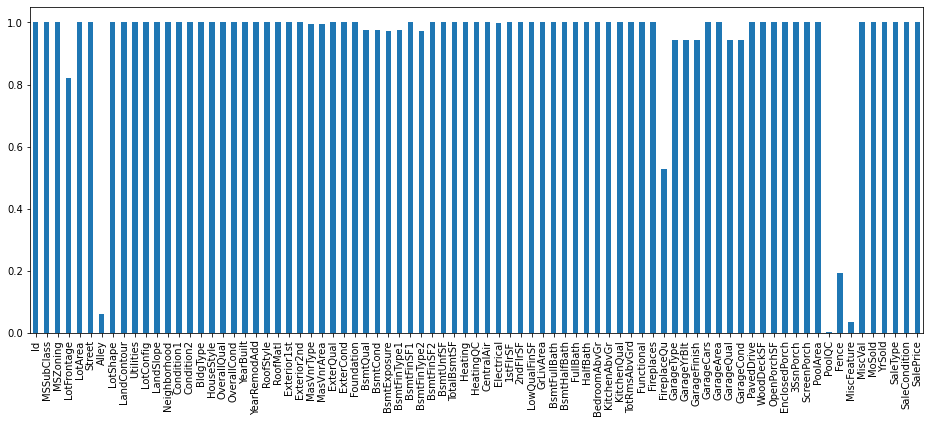

In [8]:
fig, ax = plt.subplots(figsize=(16,6))
(1 - df_raw.isnull().mean()).abs().plot.bar(ax = ax);

In [9]:
df_raw_missing = pd.DataFrame(df_raw.isnull().sum()).sort_values(by=0, ascending=False)
df_raw_missing.head(10)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81
GarageFinish,81


In [10]:
worst_columns = (df_raw_missing[df_raw_missing[0] >= (df_raw.shape[0] * 1/3)])

In [11]:
worst_columns.reset_index()

,index,0
0,PoolQC,1453
1,MiscFeature,1406
2,Alley,1369
3,Fence,1179
4,FireplaceQu,690


In [12]:
df2 =df_raw

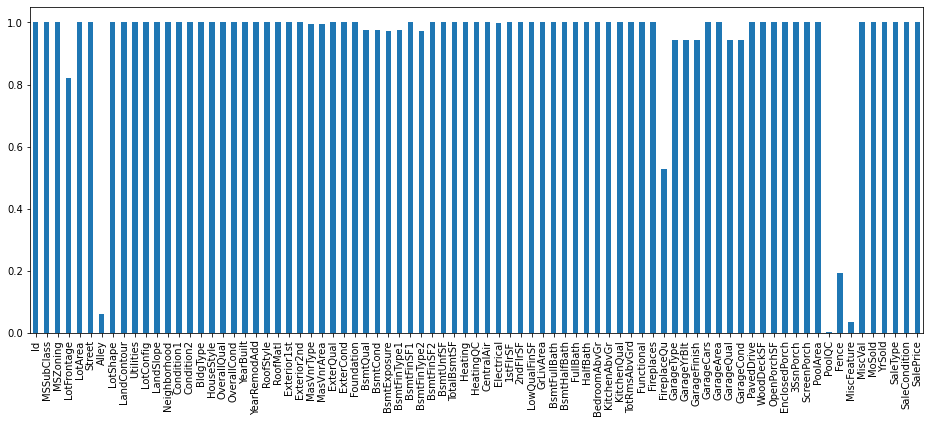

In [13]:
fig, ax = plt.subplots(figsize=(16,6))
(1 - df2.isnull().mean()).abs().plot.bar(ax = ax);

We still have missing values. We will apply feature engine ahead. 

Now, we can identify the variables and split data

In [14]:
# 'SalePrice' is the target variable
# 'Id' is an identification variable

target = 'SalePrice'
cat_vars = df2.select_dtypes(include='object').columns.to_list()
num_vars = [col for col in df2.columns if col not in cat_vars + ['Id', target]]

X = df2.filter(cat_vars + num_vars).copy()
y = df2[target].copy()

In [15]:
# Splitting data in train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=30, shuffle=True)

#### 2.3) Feature Engineering

In [16]:
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#### Missing Values: 

Numeric variables: missing values will be replaced by -999 (a value out of distribution)

Categorical variables: missing values will be replaced by the word 'Missing'

Pipeline for tree-based models

In [17]:
data_tree_pipe = Pipeline(steps=[
    ('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
    ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars, return_object=True)),
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars))
])
data_tree_pipe.fit_transform(X_train).head()

C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usual

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_CWD,SaleType_Oth,SaleType_ConLw,SaleType_Con,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_Abnorml,SaleCondition_AdjLand
327,20,80.0,11600,6,5,1960,1960,175.0,565,0,...,0,0,0,0,1,0,0,0,0,0
1061,30,120.0,18000,3,4,1935,1950,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
161,60,110.0,13688,9,5,2003,2004,664.0,1016,0,...,0,0,0,0,1,0,0,0,0,0
109,20,105.0,11751,6,6,1977,1977,480.0,705,0,...,0,0,0,0,1,0,0,0,0,0
973,20,95.0,11639,7,5,2007,2008,-999.0,0,0,...,0,0,0,0,0,1,0,0,0,0


Pipeline for linear models (same as tree-based models + feature scaling)

In [18]:
data_linear_pipe = Pipeline(steps=[
    ('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
    ('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=num_vars)),
    ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars, return_object=True)),
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars))
])
data_linear_pipe.fit_transform(X_train).head()

C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usual

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_CWD,SaleType_Oth,SaleType_ConLw,SaleType_Con,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_Abnorml,SaleCondition_AdjLand
327,-0.88486,0.488718,0.173508,-0.049542,-0.527116,-0.348867,-1.192308,0.401425,0.284286,-0.283665,...,0,0,0,0,1,0,0,0,0,0
1061,-0.64727,0.586594,0.952620,-2.219468,-1.415531,-1.171852,-1.676511,-0.469478,-0.953881,-0.283665,...,0,0,0,0,1,0,0,0,0,0
161,0.06550,0.562125,0.427693,2.120384,-0.527116,1.066668,0.938185,2.834979,1.272628,-0.283665,...,0,0,0,0,1,0,0,0,0,0
109,-0.88486,0.549891,0.191890,-0.049542,0.361299,0.210763,-0.369163,1.919286,0.591088,-0.283665,...,0,0,0,0,1,0,0,0,0,0
973,-0.88486,0.525422,0.178256,0.673767,-0.527116,1.198346,1.131866,-5.441094,-0.953881,-0.283665,...,0,0,0,0,0,1,0,0,0,0


### 3) Modeling

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [20]:
models = [
    ('linear', LinearRegression()),
    ('ridge_reg', Ridge(random_state=10)),
    ('decision_tree', DecisionTreeRegressor(random_state=10)),
    ('random_forest', RandomForestRegressor(random_state=10)),
    ('lgbm', LGBMRegressor(random_state=10)),
    ('xgb', XGBRegressor(random_state=10)),
    ('catboost', CatBoostRegressor(random_state=10))
]

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# Using cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=10)

# Metrics
metrics = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

# creating a dictionary (used to build a dataframe) with the results
dict_results = {'model': [], 'r2': [], 'mae': [], 'rmse': []}

# training and evaluating all the models selected
for model in models:
    model_pipe = Pipeline(steps=data_tree_pipe.steps + [model])

    cv_results = cross_validate(estimator=model_pipe, X=X_train, y=y_train, scoring=metrics, cv=kfold, n_jobs=-1)
    cv_results_df = pd.DataFrame(cv_results)

    r2 = cv_results_df.mean().loc['test_r2']
    mae = np.abs(cv_results_df.mean().loc['test_neg_mean_absolute_error'])
    rmse = np.abs(cv_results_df.mean().loc['test_neg_root_mean_squared_error'])

    # Filling the dict with results
    dict_results['model'].append(model_pipe.steps[-1][0])
    dict_results['r2'].append(r2)
    dict_results['mae'].append(mae)
    dict_results['rmse'].append(rmse)

df_results = pd.DataFrame(dict_results)

In [22]:
pd.options.display.float_format = '{:.4f}'.format
df_results.sort_values(by='rmse')  # The Kaggle challenge evaluates by the RMSE

,model,r2,mae,rmse
6,catboost,0.8873,14522.4244,25415.5489
4,lgbm,0.8557,17171.9188,28807.3243
3,random_forest,0.8517,17688.5416,28956.0066
5,xgb,0.8455,17991.0999,29951.6875
1,ridge_reg,0.7723,18709.4777,34572.1838
0,linear,0.7136,19236.2371,38781.8209
2,decision_tree,0.6967,26720.1698,41194.7887


In [23]:
# Selecting the best model and predicting the price in the test data
best_model = Pipeline(data_tree_pipe.steps + [('catboost', CatBoostRegressor(random_state=10))])

best_model.fit(X_train, y_train)
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test) 

C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usual

Learning rate set to 0.04196
0:	learn: 74856.0830276	total: 151ms	remaining: 2m 30s
1:	learn: 72952.9248158	total: 157ms	remaining: 1m 18s
2:	learn: 71160.2289981	total: 163ms	remaining: 54.1s
3:	learn: 69553.4746246	total: 168ms	remaining: 41.9s
4:	learn: 67800.9385769	total: 175ms	remaining: 34.8s
5:	learn: 66303.3763597	total: 181ms	remaining: 30s
6:	learn: 64657.5042024	total: 188ms	remaining: 26.7s
7:	learn: 63152.1469769	total: 194ms	remaining: 24s
8:	learn: 61625.8618170	total: 200ms	remaining: 22s
9:	learn: 60369.5204074	total: 206ms	remaining: 20.4s
10:	learn: 58981.8790679	total: 211ms	remaining: 19s
11:	learn: 57639.3975646	total: 217ms	remaining: 17.8s
12:	learn: 56424.9861071	total: 223ms	remaining: 16.9s
13:	learn: 55118.1394569	total: 228ms	remaining: 16.1s
14:	learn: 54007.3725542	total: 234ms	remaining: 15.4s
15:	learn: 52748.0039935	total: 240ms	remaining: 14.8s
16:	learn: 51649.1230937	total: 247ms	remaining: 14.3s
17:	learn: 50645.0234472	total: 252ms	remaining: 13.

167:	learn: 17529.6158103	total: 1.09s	remaining: 5.4s
168:	learn: 17503.8824108	total: 1.1s	remaining: 5.4s
169:	learn: 17463.2227111	total: 1.1s	remaining: 5.39s
170:	learn: 17439.2370455	total: 1.11s	remaining: 5.38s
171:	learn: 17400.6232928	total: 1.11s	remaining: 5.37s
172:	learn: 17362.8799176	total: 1.12s	remaining: 5.35s
173:	learn: 17317.3108624	total: 1.13s	remaining: 5.35s
174:	learn: 17292.6521261	total: 1.13s	remaining: 5.34s
175:	learn: 17259.5411932	total: 1.14s	remaining: 5.32s
176:	learn: 17217.4026939	total: 1.14s	remaining: 5.31s
177:	learn: 17182.7928569	total: 1.15s	remaining: 5.3s
178:	learn: 17140.9796280	total: 1.15s	remaining: 5.29s
179:	learn: 17097.0003505	total: 1.16s	remaining: 5.28s
180:	learn: 17033.4023084	total: 1.16s	remaining: 5.27s
181:	learn: 16978.4185825	total: 1.17s	remaining: 5.25s
182:	learn: 16943.8911900	total: 1.17s	remaining: 5.24s
183:	learn: 16889.7102324	total: 1.18s	remaining: 5.23s
184:	learn: 16855.0162620	total: 1.18s	remaining: 5.2

328:	learn: 13101.2545398	total: 2s	remaining: 4.08s
329:	learn: 13068.1892592	total: 2.01s	remaining: 4.08s
330:	learn: 13044.6412067	total: 2.02s	remaining: 4.08s
331:	learn: 13042.2520020	total: 2.02s	remaining: 4.07s
332:	learn: 13033.0888028	total: 2.03s	remaining: 4.06s
333:	learn: 13011.9238911	total: 2.04s	remaining: 4.06s
334:	learn: 12971.8902137	total: 2.04s	remaining: 4.05s
335:	learn: 12957.4024188	total: 2.05s	remaining: 4.05s
336:	learn: 12940.2901106	total: 2.05s	remaining: 4.04s
337:	learn: 12926.3643418	total: 2.06s	remaining: 4.04s
338:	learn: 12913.3206903	total: 2.07s	remaining: 4.03s
339:	learn: 12898.5073150	total: 2.07s	remaining: 4.02s
340:	learn: 12876.5125023	total: 2.09s	remaining: 4.03s
341:	learn: 12857.5192405	total: 2.09s	remaining: 4.03s
342:	learn: 12846.4134836	total: 2.1s	remaining: 4.02s
343:	learn: 12818.7066073	total: 2.1s	remaining: 4.01s
344:	learn: 12806.2322160	total: 2.11s	remaining: 4s
345:	learn: 12781.9879892	total: 2.12s	remaining: 4s
346

486:	learn: 10482.7293481	total: 2.96s	remaining: 3.12s
487:	learn: 10475.2906359	total: 2.97s	remaining: 3.11s
488:	learn: 10449.2528394	total: 2.97s	remaining: 3.1s
489:	learn: 10426.9663479	total: 2.98s	remaining: 3.1s
490:	learn: 10406.9766582	total: 2.98s	remaining: 3.09s
491:	learn: 10382.8476552	total: 2.99s	remaining: 3.08s
492:	learn: 10361.9999334	total: 2.99s	remaining: 3.08s
493:	learn: 10350.5799041	total: 3s	remaining: 3.07s
494:	learn: 10331.7248443	total: 3s	remaining: 3.06s
495:	learn: 10313.7541379	total: 3.01s	remaining: 3.06s
496:	learn: 10298.1121260	total: 3.02s	remaining: 3.05s
497:	learn: 10291.8276569	total: 3.02s	remaining: 3.04s
498:	learn: 10271.2990470	total: 3.02s	remaining: 3.04s
499:	learn: 10265.3112502	total: 3.03s	remaining: 3.03s
500:	learn: 10250.1701346	total: 3.04s	remaining: 3.02s
501:	learn: 10233.8244388	total: 3.04s	remaining: 3.02s
502:	learn: 10225.9164721	total: 3.04s	remaining: 3.01s
503:	learn: 10214.0000714	total: 3.05s	remaining: 3s
504

649:	learn: 8374.8376629	total: 3.91s	remaining: 2.1s
650:	learn: 8360.0088168	total: 3.91s	remaining: 2.1s
651:	learn: 8342.5206372	total: 3.92s	remaining: 2.09s
652:	learn: 8340.9154886	total: 3.92s	remaining: 2.08s
653:	learn: 8324.0214009	total: 3.93s	remaining: 2.08s
654:	learn: 8322.5845685	total: 3.94s	remaining: 2.07s
655:	learn: 8300.7748847	total: 3.94s	remaining: 2.07s
656:	learn: 8294.7398360	total: 3.95s	remaining: 2.06s
657:	learn: 8291.1877790	total: 3.95s	remaining: 2.05s
658:	learn: 8279.6105398	total: 3.96s	remaining: 2.05s
659:	learn: 8263.8495336	total: 3.96s	remaining: 2.04s
660:	learn: 8246.0386593	total: 3.97s	remaining: 2.04s
661:	learn: 8231.8865854	total: 3.97s	remaining: 2.03s
662:	learn: 8216.6559578	total: 3.98s	remaining: 2.02s
663:	learn: 8200.4468699	total: 3.99s	remaining: 2.02s
664:	learn: 8199.5421323	total: 3.99s	remaining: 2.01s
665:	learn: 8188.6305083	total: 4s	remaining: 2s
666:	learn: 8173.0439415	total: 4s	remaining: 2s
667:	learn: 8166.3073317

808:	learn: 6860.5531892	total: 4.83s	remaining: 1.14s
809:	learn: 6851.9476547	total: 4.84s	remaining: 1.14s
810:	learn: 6840.5703350	total: 4.85s	remaining: 1.13s
811:	learn: 6825.4556098	total: 4.86s	remaining: 1.12s
812:	learn: 6818.5538832	total: 4.86s	remaining: 1.12s
813:	learn: 6808.8651096	total: 4.87s	remaining: 1.11s
814:	learn: 6799.3045533	total: 4.87s	remaining: 1.11s
815:	learn: 6788.8544222	total: 4.88s	remaining: 1.1s
816:	learn: 6781.8578194	total: 4.88s	remaining: 1.09s
817:	learn: 6765.6553511	total: 4.89s	remaining: 1.09s
818:	learn: 6758.7855239	total: 4.89s	remaining: 1.08s
819:	learn: 6747.9332580	total: 4.9s	remaining: 1.07s
820:	learn: 6741.2126556	total: 4.9s	remaining: 1.07s
821:	learn: 6733.4805807	total: 4.91s	remaining: 1.06s
822:	learn: 6727.9302405	total: 4.92s	remaining: 1.06s
823:	learn: 6720.2571112	total: 4.92s	remaining: 1.05s
824:	learn: 6713.3715084	total: 4.93s	remaining: 1.04s
825:	learn: 6703.6636235	total: 4.93s	remaining: 1.04s
826:	learn: 6

961:	learn: 5722.3186174	total: 5.76s	remaining: 227ms
962:	learn: 5721.7100080	total: 5.76s	remaining: 221ms
963:	learn: 5715.5072555	total: 5.77s	remaining: 215ms
964:	learn: 5708.9044913	total: 5.78s	remaining: 210ms
965:	learn: 5708.4105225	total: 5.78s	remaining: 204ms
966:	learn: 5703.3657269	total: 5.79s	remaining: 198ms
967:	learn: 5695.0796396	total: 5.8s	remaining: 192ms
968:	learn: 5684.1465139	total: 5.8s	remaining: 186ms
969:	learn: 5676.6666801	total: 5.81s	remaining: 180ms
970:	learn: 5668.1389286	total: 5.82s	remaining: 174ms
971:	learn: 5667.5212719	total: 5.82s	remaining: 168ms
972:	learn: 5665.7379910	total: 5.83s	remaining: 162ms
973:	learn: 5659.5092038	total: 5.83s	remaining: 156ms
974:	learn: 5658.6342555	total: 5.84s	remaining: 150ms
975:	learn: 5652.0782224	total: 5.84s	remaining: 144ms
976:	learn: 5643.4196653	total: 5.85s	remaining: 138ms
977:	learn: 5641.7134944	total: 5.85s	remaining: 132ms
978:	learn: 5633.2733783	total: 5.86s	remaining: 126ms
979:	learn: 

C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usual

C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usual

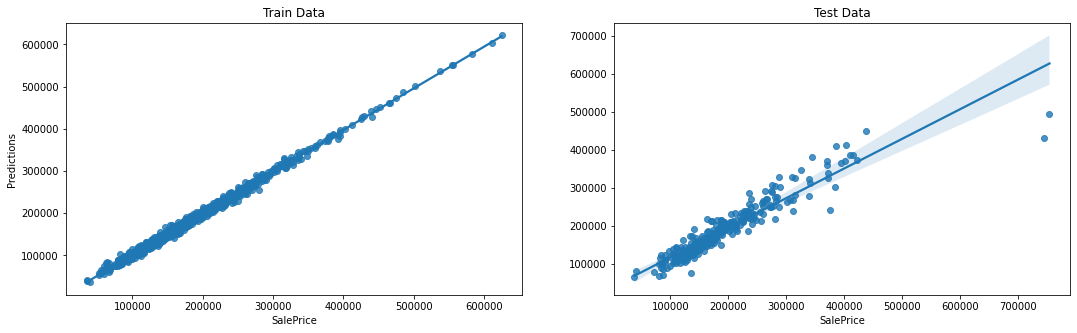

In [24]:
#Comparing perfomance in train and test
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
sns.regplot(x=y_train, y=y_pred_train, ax=ax[0])
sns.regplot(x=y_test, y=y_pred_test, ax=ax[1])
ax[0].set_ylabel('Predictions')
ax[0].set_title('Train Data')
ax[1].set_title('Test Data');

In [25]:
# Calculating the metrics in the test data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error


def adjusted_r2(y_real, y_predict, X_train):
    R2 = r2_score(y_real, y_predict)
    N = len(y_real)
    p = X_train.shape[1]

    r2_adjust = (1 - ((1 - R2) * (N - 1)) / (N - p - 1))
    return r2_adjust

r2_adjust = adjusted_r2(y_test, y_pred_test, X_train)
print('Adjusted R2:', r2_adjust)
print()
mae = mean_absolute_error(y_test, y_pred_test)
print('MAE:', mae)

mse = mean_squared_error(y_test, y_pred_test)
print('MSE:', mse)

rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print('RMSE:', rmse)

rmsle = mean_squared_log_error(y_test, y_pred_test, squared=False)
print('RMSLE:', rmsle)
print()
m_error = max_error(y_test, y_pred_test)
print('Max Error:', m_error)

mape = mean_absolute_percentage_error(y_test, y_pred_test)
print('MAPE:', mape)


Adjusted R2: 0.8181990232100116

MAE: 16829.210646887834
MSE: 1029491074.4407667
RMSE: 32085.68332513376
RMSLE: 0.13151770013870898

Max Error: 312754.93077261606
MAPE: 0.0899793941973355


Predict the challenge data

In [26]:
challenge_data = df_test.drop('Id', axis=1)

In [27]:
prices = best_model.predict(challenge_data)

C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\diego\anaconda3\envs\ds1\lib\site-packages\feature_engine\encoding\one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [28]:
df_test['SalePrice'] = prices

In [29]:
submission = df_test[['Id','SalePrice']]
submission.to_csv('submission_07.csv',index=False)

#### This model performed a score of 0.12708 in Kaggle Competition